<a href="https://colab.research.google.com/github/N34R20/PySpark/blob/main/Machine_Learning_Distribuido_con_Spark_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning con Spark

[**MLlib**](https://spark.apache.org/docs/latest/ml-guide.html) es la biblioteca de machine learning (ML) de Spark. Permite realizar tareas de ML de forma escalable y fácil.

A un alto nivel, proporciona herramientas como:

* Algoritmos de ML: Como serian clasificación, regresión, clustering y filtrado colaborativo
* Featurization: extracción de features, transformación, reducción de dimensionalidad y selección de features
* Pipelines: herramientas para construir, evaluar y ajustar ML Pipelines
* Persistencia: guardar y cargar algoritmos, modelos y Pipelines
* Utilidades: álgebra lineal, estadística, manejo de datos, etc.


Trabajando con MLlib es vamos a usar objetos de los siquientes tipos:

* `DataFrame`: MLlib usa DataFrames de Spark SQL como un dataset de datos de ML, que puede contener una variedad de tipos de datos. Por ejemplo, un DataFrame podría tener diferentes columnas que almacenan texto, vectores de características, etiquetas verdaderas y predicciones.

* `Transformer`: Un `Transformer` es un algoritmo que puede transformar un DataFrame en otro. Por ejemplo, un modelo de ML es un `Transformer` que transforma un DataFrame con features a uno con predicciones.

* `Estimator`: Un `Estimator` es un algoritmo que se puede ajustar (fittear) en un DataFrame para producir un `Transformer`. Por ejemplo, un algoritmo de ML es un `Estimator` que se entrena con un DataFrame y produce un modelo.

* `Pipeline`: Un `Pipeline` encadena varios transformadores y estimadores para definir un workflow de ML.

## Workflow Habitual de ML

En el siguiente diagrama podemos ver como es el flujo de trabajo habitual de un proyecto de ML:

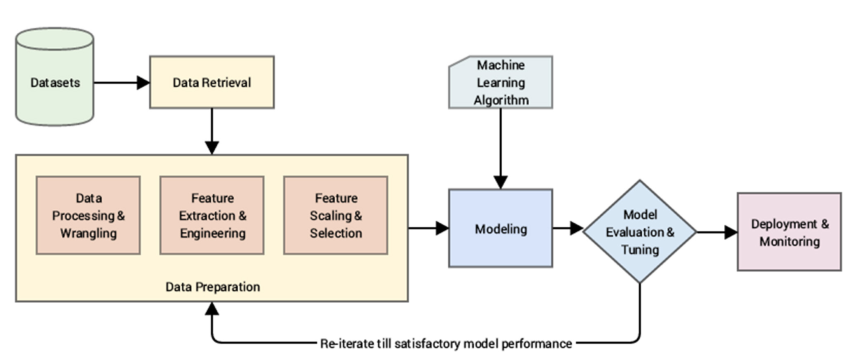

Como podemos ver las etapas presentes tienen un mapeo directo con las features que nos ofrece MLlib.


# Setup

---

Primero installamos PySpark.

In [ ]:
!pip install pyspark -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Creamos el cliente de Spark.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

# Carga de Datos

Para ilustrar los temas vamos a utilizar a modo de ejemplo el dataset [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) el cual contiene datos de mediciones de caracteristicas de plantes y es facil de analizar.
En este dataset cada linea contiene datos de un individuo en particular (columnas `sepal_length`, `sepal_width`, `petal_length` y `petal_width`) y la variedad a la cual pertenece (columna `class`).

Ahora si vamos a bajar el dataset de prueba y lo cargamos en un DataFrame.


In [ ]:
!wget https://gist.github.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv

--2023-09-06 00:52:25--  https://gist.github.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv
Resolving gist.github.com (gist.github.com)... 192.30.255.113
Connecting to gist.github.com (gist.github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv [following]
--2023-09-06 00:52:25--  https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3975 (3.9K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   3.88K  --.-KB/s    in 0s      

2023-09-06 00:

In [ ]:
import pandas as pd
raw_df = spark.createDataFrame(pd.read_csv('iris.csv', skiprows=1, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']))
raw_df.show()

+------------+-----------+------------+-----------+------+
|sepal_length|sepal_width|petal_length|petal_width| class|
+------------+-----------+------------+-----------+------+
|         5.1|        3.5|         1.4|        0.2|Setosa|
|         4.9|        3.0|         1.4|        0.2|Setosa|
|         4.7|        3.2|         1.3|        0.2|Setosa|
|         4.6|        3.1|         1.5|        0.2|Setosa|
|         5.0|        3.6|         1.4|        0.2|Setosa|
|         5.4|        3.9|         1.7|        0.4|Setosa|
|         4.6|        3.4|         1.4|        0.3|Setosa|
|         5.0|        3.4|         1.5|        0.2|Setosa|
|         4.4|        2.9|         1.4|        0.2|Setosa|
|         4.9|        3.1|         1.5|        0.1|Setosa|
|         5.4|        3.7|         1.5|        0.2|Setosa|
|         4.8|        3.4|         1.6|        0.2|Setosa|
|         4.8|        3.0|         1.4|        0.1|Setosa|
|         4.3|        3.0|         1.1|        0.1|Setos

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Vectorizamos todas las columnas numéricas en una sola columna de features.
# La API de MLlib requiere que usemos este formato.
feature_cols = raw_df.columns[:-1]  # Tomamos todas las columnas.
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
data = assembler.transform(raw_df)


# Estadistica Descriptiva
---

Antes de empezar a trabajar es recomendable estudiar los datos que tenemos para entenderlos mejor, verificar si necesitan limpieza y evaluar estrategias para resolver el problema que nos interese.

Para esto vamos a usar el objeto [Summarizer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.stat.Summarizer.html) el cual nos generara métricas utiles para explorar los datos.

La salida del metodo `summary` es un DataFrame de tuplas correspondientes a cada campo y a cada valor estadistico que hayamos requerido. Para el campo `count` solo devuelve un solo resultado debido a que se trata del conteo total de filas.

In [ ]:
from pyspark.ml.stat import Summarizer

summarizer = Summarizer.metrics(
  "count",
  "mean",
  "sum",
  "variance",
  "std",
  "max",
  "min",
)

# Computamos las metricas
rv = data.select(summarizer.summary(data.features)).show(truncate=False)
rv

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|aggregate_metrics(features, 1.0)                                                                                                                                                                                                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Intro a Clasificacion con MLlib

Como se menciono anteriormente MLlib ofrece una variedad de algoritmos que podemos utilizar para distintos problemas de Machine Learning:

* Clasificación: Prediccion de clases discretas.
* Regresión: Prediccion de valores continuos. discretas.
* Clustering: Identificar grupos de elementos similares.
* Filtrado Colaborativo: Metodo comunmente usando para generar recomendaciones. Apunta a rellenar valores desconocidos a partir de otras obsevaciones. Una aplicacionde esto es predecir el rating que un usuario le daria a una pelicula de lo cual se puede usar para recomendarsela.
* Frequent Pattern Mining: Identificacion de patrones recurrentes en secuencias o grupos.


A modo de ejemplo vamos a considerar el problema de clasificacion de los individuos de dataset segun su variedad.

## Transformacion de Datos

MLlib nos ofrece una [amplia variedad de transformaciones de datos](https://spark.apache.org/docs/latest/ml-features.html) entre las que podemos mencionar:

* [MinMaxScaler](https://spark.apache.org/docs/latest/ml-features.html#minmaxscaler): Normaliza las escalas de los features.
* [FeatureHasher](https://spark.apache.org/docs/latest/ml-features.html#featurehasher): Para trabajar con datos categoricos de alta cardinalidad.
* [Tokenizer](https://spark.apache.org/docs/latest/ml-features.html#tokenizer): Para partir textos en unidades mas chicas.
* [Word2Vec](https://spark.apache.org/docs/latest/ml-features.html#word2vec): Nos permite convertir palabras en vectores numericos que preservan su significado semantico.



Continuando con el ejemplo podemos ver en la metrica `mean` computada anteriormente el promedio de los las distintas variables es diferente. Esto puede ser un problema para algunos algoritmos de ML. Para resolverlo vamos a llevar todas las variables a valores en 0 y 1.

In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Ajustamos el modelo de MinMaxScalerModel a nuestros datos
scalerModel = scaler.fit(data)

# Rescalamos cada feature al rango [0, 1].
transformed_data = scalerModel.transform(data)
print("Features escaladas al rango: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
transformed_data.select("features", "scaledFeatures").show()


Features escaladas al rango: [0.000000, 1.000000]
+-----------------+--------------------+
|         features|      scaledFeatures|
+-----------------+--------------------+
|[5.1,3.5,1.4,0.2]|[0.22222222222222...|
|[4.9,3.0,1.4,0.2]|[0.16666666666666...|
|[4.7,3.2,1.3,0.2]|[0.11111111111111...|
|[4.6,3.1,1.5,0.2]|[0.08333333333333...|
|[5.0,3.6,1.4,0.2]|[0.19444444444444...|
|[5.4,3.9,1.7,0.4]|[0.30555555555555...|
|[4.6,3.4,1.4,0.3]|[0.08333333333333...|
|[5.0,3.4,1.5,0.2]|[0.19444444444444...|
|[4.4,2.9,1.4,0.2]|[0.02777777777777...|
|[4.9,3.1,1.5,0.1]|[0.16666666666666...|
|[5.4,3.7,1.5,0.2]|[0.30555555555555...|
|[4.8,3.4,1.6,0.2]|[0.13888888888888...|
|[4.8,3.0,1.4,0.1]|[0.13888888888888...|
|[4.3,3.0,1.1,0.1]|[0.0,0.4166666666...|
|[5.8,4.0,1.2,0.2]|[0.41666666666666...|
|[5.7,4.4,1.5,0.4]|[0.38888888888888...|
|[5.4,3.9,1.3,0.4]|[0.30555555555555...|
|[5.1,3.5,1.4,0.3]|[0.22222222222222...|
|[5.7,3.8,1.7,0.3]|[0.38888888888888...|
|[5.1,3.8,1.5,0.3]|[0.22222222222222...|
+------

Aparte de eso tambien necesitamos convertir la clase que es una columna textual a un indice numerico.

In [ ]:
from pyspark.ml.feature import StringIndexer

# Convertimos las feature textuales en indices.
label_indexer = StringIndexer(inputCol='class', outputCol='label').fit(transformed_data)
transformed_data = label_indexer.transform(transformed_data)

In [ ]:
transformed_data.show()

+------------+-----------+------------+-----------+------+-----------------+--------------------+-----+
|sepal_length|sepal_width|petal_length|petal_width| class|         features|      scaledFeatures|label|
+------------+-----------+------------+-----------+------+-----------------+--------------------+-----+
|         5.1|        3.5|         1.4|        0.2|Setosa|[5.1,3.5,1.4,0.2]|[0.22222222222222...|  0.0|
|         4.9|        3.0|         1.4|        0.2|Setosa|[4.9,3.0,1.4,0.2]|[0.16666666666666...|  0.0|
|         4.7|        3.2|         1.3|        0.2|Setosa|[4.7,3.2,1.3,0.2]|[0.11111111111111...|  0.0|
|         4.6|        3.1|         1.5|        0.2|Setosa|[4.6,3.1,1.5,0.2]|[0.08333333333333...|  0.0|
|         5.0|        3.6|         1.4|        0.2|Setosa|[5.0,3.6,1.4,0.2]|[0.19444444444444...|  0.0|
|         5.4|        3.9|         1.7|        0.4|Setosa|[5.4,3.9,1.7,0.4]|[0.30555555555555...|  0.0|
|         4.6|        3.4|         1.4|        0.3|Setosa|[4.6,3

# Split de Datos

Para poder evaluar correctamente el modelo tenemos que entrenarlo sobre un dataset y luego evaluarlo contra otro. Con esto vamos a poder determinar si el modelo en lugar de aprender de los datos los memorizo (lo que se llama habitualmente overfitting).



In [ ]:
(train_data, test_data) = transformed_data.randomSplit([0.7, 0.3])

# Entrenamiento del Modelo

Ahora que tenemos data preparada vamos a entrenar un modelo de arbol de decision que nos permitira clasificar cada fila segun su clase.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(train_data)


# Evaluacion de performance

In [ ]:
# Generamos las predicciones del modelo.
predictions = model.transform(test_data)
predictions.select("prediction").show()

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
+----------+
only showing top 20 rows



Ahora con las predicciones en el dataset de test vamos obtener el accuracy del modelo. Esto es el porcentaje de veces que el modelo hace una prediccion correcta sobre de clase sobre datos no vistos.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {round(accuracy * 100, 2)} %")

Accuracy = 97.78 %


# Evaluacion de Performance: Cross Validation

Cuando evaluamos la performance de un modelo de ML usando una particion aleatoria de nuestro dataset en train y test puede ocurrir que obtengamos un score distinto de si tomamos otra particion. Esto es un problema particularmente marcado en datasets de tamaño reducido y alta variabilidad.

Para solucionar este problema se lleva a cabo un proceso llamado cross-validation. Aqui se divide en dataset en particiones igual que se usan alternativamente para entrenar y evaluar. Cada corrida produce un score que los cuales se promedian para generar el score final del modelo.

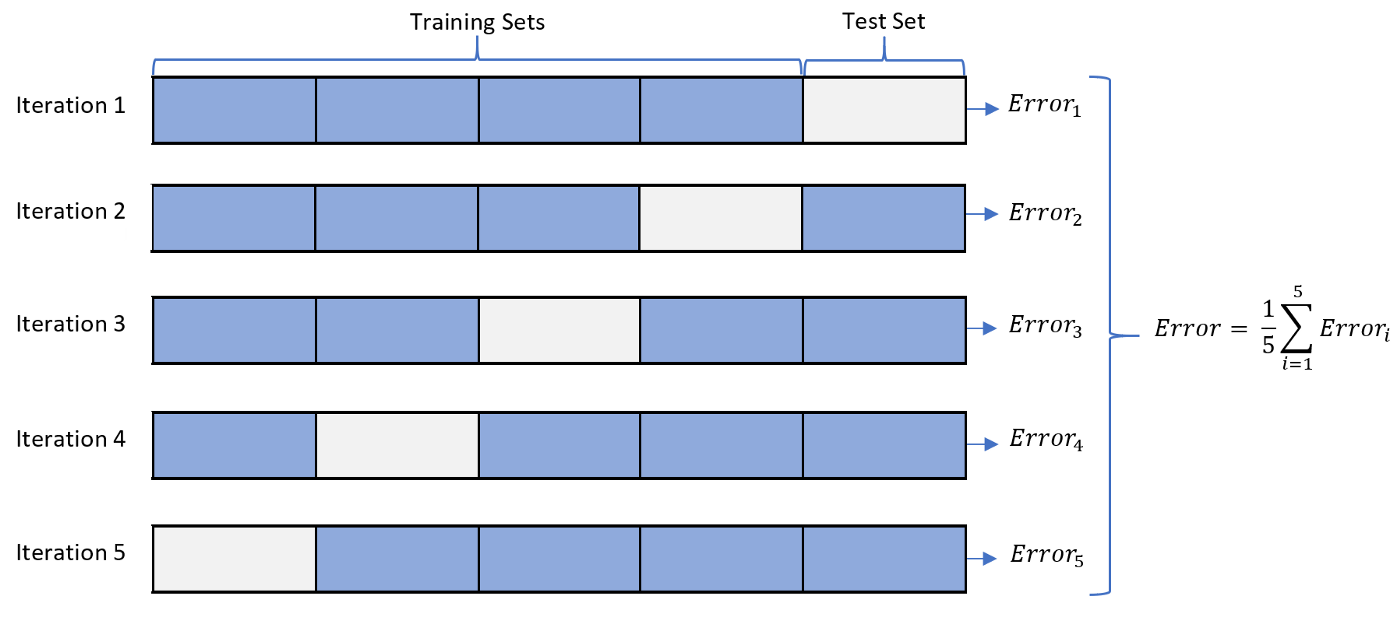

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder().build()

crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)  # Usamos 3 folds pero en la practica se usan mas

# Corremos cross-validation.
cvModel = crossval.fit(transformed_data)
print(f"Average accuracy for all folds = {round(cvModel.avgMetrics[0] * 100, 2)} %")

Average accuracy for all folds = 96.7 %


# Tunneo de hiperparametros

Una caracteristica de los algoritmos de ML que producen los modelos es que tienen parametros que controlan la ejecucion de los mismos pero no son aprendidos de la data.
Estos parametros pueden tener gran impacto en los datos por lo cual es deseable encontrar su mejor configuracion posible, este proceso se llama hyperparameter tuning. Para hacer esto se realizan procesos de busqueda que pueden tener distintos niveles de complejidad, en el caso de MLlib se utiliza una forma basica que consiste en probar combinaciones secuencialmente.



In [ ]:
from pyspark.ml.tuning import TrainValidationSplit

paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [1, 5, 10]) \
    .build()

tvs = TrainValidationSplit(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=.7,
)

# Corremos cross-validation.
model_tvs = tvs.fit(transformed_data)
print(f"Accuracy de cada modelo entrenado = {model_tvs.validationMetrics}")

# En este punto

Accuracy de cada modelo entrenado = [0.6666666666666666, 0.9487179487179487, 0.9487179487179487]


In [ ]:
from pprint import pprint
print(f"Accuracy of each trained model = {model_tvs.params}")
print(f"Mejor modelo entrenado: {model_tvs.bestModel}")

Accuracy of each trained model = [Param(parent='TrainValidationSplitModel_9e85bf05dc2a', name='estimator', doc='estimator to be cross-validated'), Param(parent='TrainValidationSplitModel_9e85bf05dc2a', name='estimatorParamMaps', doc='estimator param maps'), Param(parent='TrainValidationSplitModel_9e85bf05dc2a', name='evaluator', doc='evaluator used to select hyper-parameters that maximize the validator metric'), Param(parent='TrainValidationSplitModel_9e85bf05dc2a', name='seed', doc='random seed.'), Param(parent='TrainValidationSplitModel_9e85bf05dc2a', name='trainRatio', doc='Param for ratio between train and     validation data. Must be between 0 and 1.')]
Mejor modelo entrenado: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_6b72213fcd7a, depth=5, numNodes=17, numClasses=3, numFeatures=4


# Persistiendo Modelos

MLlib tambien nos permite guardar modelos para luego usarlos nuevamente.


In [ ]:
!if [ -d "/tmp/model" ]; then rm -r /tmp/model; fi

In [ ]:
# Salvamos el modelo
from pyspark.ml.classification import DecisionTreeClassificationModel
model.save("/tmp/model")

In [ ]:
!ls -Rl /tmp/model

/tmp/model:
total 8
drwxr-xr-x 2 root root 4096 Sep  6 01:03 data
drwxr-xr-x 2 root root 4096 Sep  6 01:03 metadata

/tmp/model/data:
total 4
-rw-r--r-- 1 root root 4051 Sep  6 01:03 part-00000-117b8a26-45e1-44b0-a49d-76804817102d-c000.snappy.parquet
-rw-r--r-- 1 root root    0 Sep  6 01:03 _SUCCESS

/tmp/model/metadata:
total 4
-rw-r--r-- 1 root root 641 Sep  6 01:03 part-00000
-rw-r--r-- 1 root root   0 Sep  6 01:03 _SUCCESS


In [ ]:
# Lo cargamos y comprobamos que funciona correctamente.
model_loaded = DecisionTreeClassificationModel.load("/tmp/model")
predictions = model_loaded.transform(test_data)
predictions.select("prediction").show()

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
+----------+
only showing top 20 rows



# Pipelines

La funcionalidad de [ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) proporciona un conjunto uniforme de APIs de alto nivel que ayudan a crear y fittear conjuntos de operaciones de manera sencilla.

Para cerrar vamos ver como encadenar las operaciones vistas hasta ahora en el ejemplo en un pipeline.


In [ ]:
from pyspark.ml import Pipeline

# Cargamos los datos
raw_df = spark.createDataFrame(
    pd.read_csv(
        'iris.csv',
        skiprows=1,
        names=[
            'sepal_length',
            'sepal_width',
            'petal_length',
            'petal_width',
            'class'
        ]
    )
)

# Generamos un split de datos al comienzo.
(train_raw_df, test_raw_df) = raw_df.randomSplit([0.7, 0.3])

# Creamos las mismas transformacion de los pasos anteriores de antemano.
feature_cols = raw_df.columns[:-1]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
label_indexer = StringIndexer(inputCol='class', outputCol='label')
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaledFeatures")

# Creamos el Pipeline que encadena las transformaciones.
pipeline = Pipeline(stages=[assembler, scaler, label_indexer, dt])

# Fitteamos todos los pasos del pipeline.
model = pipeline.fit(train_raw_df)

# Generamos las predicciones
predictions = model.transform(test_raw_df)

# Evaluamos la performance del modelo.
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {round(accuracy * 100, 2)} %")


Accuracy = 97.73 %


 # Referencias

 * https://spark.apache.org/docs/latest/ml-guide.html